In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from collections.abc import Generator
from typing_extensions import TypeAlias
from dataclasses import dataclass, asdict, astuple
from functools import partial

import numpy as np

import datasets
from datasets import Dataset, DatasetInfo, load_from_disk, Features, Value, ClassLabel, Sequence

jax.enable_checks = True

jax.devices()

2023-09-19 15:48:31.331257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-19 15:48:33.584506: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

# Payoff

In [2]:
class EuropeanPayoff:

    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

# Smoothing

## test sequence

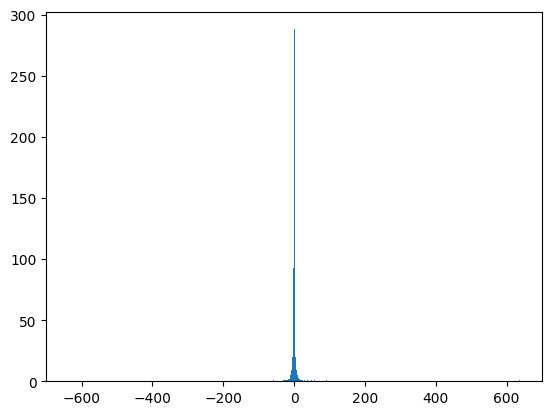

In [11]:
def zero_centered_sequence(n):
    k = jnp.arange(1, n + 1)
    nodes = jnp.tan((2 * k - 1) * jnp.pi / (2 * n))
    return nodes

# Number of points in the sequence
n = 1000  # Adjust as needed

# Generate the Chebyshev like zero-centered sequence
sequence = zero_centered_sequence(n)
plt.hist(sequence, bins=1000)
plt.show()

In [12]:

def plot_smoothing(xs, ys, dys):
    plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
    plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
    plt.legend()
    plt.xlim([-1e0, 1e0])
    plt.ylim([-0.1, 1])
    plt.show()

## sigmoidal smoothing

0.001001001001001034


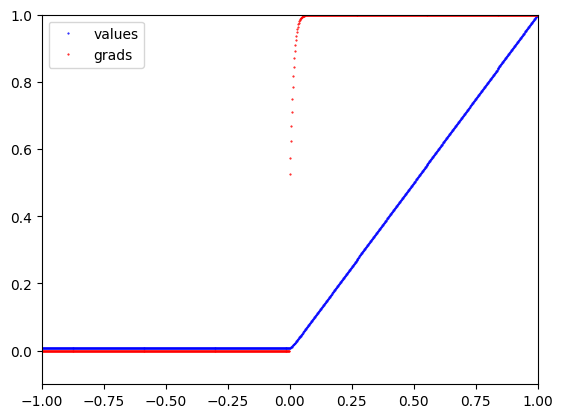

In [13]:
jax.clear_caches()
def sigmoidal_smoothing(f, k=100.0):

    def smooth_f(*args):
        return 1.0/k * jnp.log(1.0 + jnp.exp(k * f(*args)))

    return smooth_f

smooth_max = sigmoidal_smoothing(lambda x: jnp.maximum(0.0, x))

# xs = sequence
xs = jnp.linspace(-1, 1, 1000)
print(jnp.min(jnp.abs(xs)))
ys_true = jnp.maximum(0.0, xs)
# print("xs", xs)
# print("ys_true", ys_true)

ys, dys = jax.vmap(jax.value_and_grad(smooth_max))(xs)
plot_smoothing(xs, ys, dys)


## cubic spline smoothing

In [3]:
# cubic spline smoothing from:
# https://link.springer.com/article/10.1007/s00780-009-0097-9

def cubic_spline_smoothing(f, k=1e-3):
    @jit
    def smooth_f(*args):
        x = f(*args)
        i = jnp.argwhere(jnp.array([x < -k, x <= k, True]), size=1).squeeze()
        below = lambda x: jnp.zeros_like(x)
        poly = lambda x: -1/(16*(k**3)) * x**4 + 3/(8*k) * x**2 + .5*x + (3*k)/16
        above = lambda x: x
        return jax.lax.switch(i, [below, poly, above], x)

    return smooth_f


smooth_max_cubic = cubic_spline_smoothing(partial(jnp.maximum, 0.0))

ys_error 9.375e-05


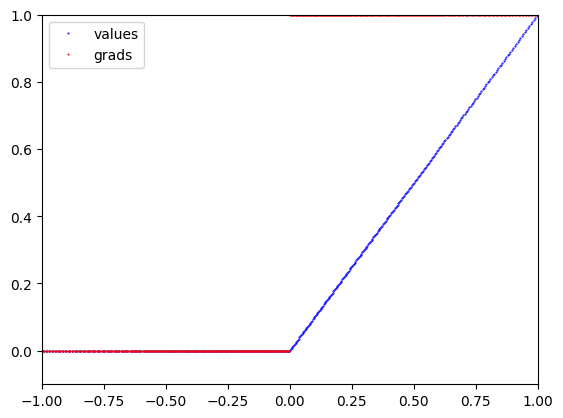

ys_error 0.00010556249999999998


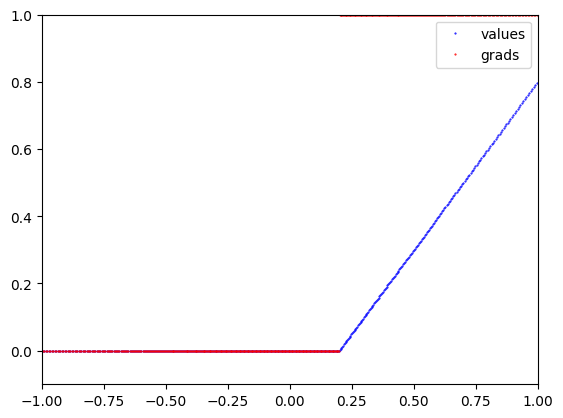

In [16]:
xs = sequence
ys_true = jnp.maximum(0.0, xs)
ys, dys = jax.vmap(jax.value_and_grad(smooth_max_cubic))(xs)
print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)

euro_payoff = partial(EuropeanPayoff.call, strike_prices=.2)
euro_smooth = cubic_spline_smoothing(euro_payoff)
ys_true = euro_payoff(xs)
ys, dys = vmap(jax.value_and_grad(euro_smooth))(xs)
print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)


# Checkpointing of scan

In [4]:
# Copyright 2022 Google LLC.
# SPDX-License-Identifier: Apache-2.0
# from: https://github.com/google/jax/issues/2139#issuecomment-1189382794
import math
import typing
from typing import Any, Callable, Optional, Sequence, Tuple, TypeVar, Union

import jax
import jax.numpy as jnp


Carry = TypeVar('Carry')
Input = TypeVar('Input')
Output = TypeVar('Output')
Func = TypeVar('Func', bound=Callable)


def nested_checkpoint_scan(
    f: Callable[[Carry, Input], Tuple[Carry, Output]],
    init: Carry,
    xs: Input,
    length: Optional[int] = None,
    *,
    nested_lengths: Sequence[int],
    scan_fn = jax.lax.scan,
    checkpoint_fn: Callable[[Func], Func] = jax.checkpoint,
) -> Tuple[Carry, Output]:
  """A version of lax.scan that supports recursive gradient checkpointing.

  The interface of `nested_checkpoint_scan` exactly matches lax.scan, except for
  the required `nested_lengths` argument.

  The key feature of `nested_checkpoint_scan` is that gradient calculations
  require O(max(nested_lengths)) memory, vs O(prod(nested_lengths)) for unnested
  scans, which it achieves by re-evaluating the forward pass
  `len(nested_lengths) - 1` times.

  `nested_checkpoint_scan` reduces to `lax.scan` when `nested_lengths` has a
  single element.

  Args:
    f: function to scan over.
    init: initial value.
    xs: scanned over values.
    length: leading length of all dimensions
    nested_lengths: required list of lengths to scan over for each level of
      checkpointing. The product of nested_lengths must match length (if
      provided) and the size of the leading axis for all arrays in ``xs``.
    scan_fn: function matching the API of lax.scan
    checkpoint_fn: function matching the API of jax.checkpoint.

  Returns:
    Carry and output values.
  """
  if length is not None and length != math.prod(nested_lengths):
    raise ValueError(f'inconsistent {length=} and {nested_lengths=}')

  def nested_reshape(x):
    x = jnp.asarray(x)
    new_shape = tuple(nested_lengths) + x.shape[1:]
    return x.reshape(new_shape)

  sub_xs = jax.tree_map(nested_reshape, xs)
  return _inner_nested_scan(f, init, sub_xs, nested_lengths, scan_fn,
                            checkpoint_fn)


def _inner_nested_scan(f, init, xs, lengths, scan_fn, checkpoint_fn):
  """Recursively applied scan function."""
  if len(lengths) == 1:
    return scan_fn(f, init, xs, lengths[0])

  @checkpoint_fn
  def sub_scans(carry, xs):
    return _inner_nested_scan(f, carry, xs, lengths[1:], scan_fn, checkpoint_fn)

  carry, out = scan_fn(sub_scans, init, xs, lengths[0])
  stacked_out = jax.tree_map(jnp.concatenate, out)
  return carry, stacked_out

# Heston

In [5]:
class ModelState(eqx.Module):
    S0: float
    v0: float
    
class Heston(eqx.Module):

    # the state of the model at any given 
    class State(eqx.Module):
        S0: float
        v0: float
        
    # European call option price is at 34.99 for the following config: 
    class Parameters(eqx.Module):
        K: float = 100.0        # Strike price
        r: float = 0.05         # Risk-free rate
        T: float = 5.0          # n years until expiry, i.e. T2 - T1
        rho: float = -0.3       # Correlation of asset and volatility
        kappa: float = 2.00     # Mean-reversion rate
        theta: float = 0.09     # Long run average volatility
        xi: float = 1.00        # Volatility of volatility
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    v0: float = 0.09        # Initial volatility

    @classmethod
    def from_parameters(cls, parameters: Parameters, **kwargs):
        return cls(*astuple(parameters), **kwargs)
    
    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)


def volatility_path(v0, vol_draws, self):
    n_steps = len(vol_draws)
    dt = self.T / n_steps

    def vol_path_iter(prev_vol_path, vol_draw):
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_steps)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path


def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_steps = len(spot_draws)
    dt = self.T / n_steps

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        v_truncated = smooth_max_cubic(vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_steps)
    
    # we now have iteration 1 at position 0. Place initial S0 at the end and rotate into initial slot
    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def model_state_path(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    return s_path


def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
    payoff = smooth_payoff_fn(spot_maturity, self.K)
    return payoff


def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    return payoff(self, model_state_path(state, self, vol_draws, spot_draws))


@eqx.filter_jit
def correlated_draws(self: Heston, key, n_samples: int):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])
    
    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))
    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws


def path_fn(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    # jax.debug.print("hest spots: {}", self.S0.shape)
    # jax.debug.print("hest vols: {}", self.v0.shape)
    # jax.debug.print("corr draws key: {}", key.shape)
    # jax.debug.print("hest time: {}", self.T)
    # n_time_steps = jnp.asarray(self.T * n_time_steps_per_year, int)
    # n_time_steps = self.T * n_time_steps_per_year
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self.model_state, self, vol_draws, spot_draws)


def differential_path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    # n_time_steps = self.T * n_time_steps_per_year
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    p, dp = jax.value_and_grad(path_and_payoff)(self.model_state, self, vol_draws, spot_draws)
    return p, dp


In [6]:
@jax.jit
def f_long(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = jnp.maximum(0.0, prev_vol_path) # TODO: Needs smoothing!
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    #carry, vol_path = nested_checkpoint_scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter, nested_lengths=[1000, n_iter // 1000])
    
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path

In [24]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  K=100.0,
  r=0.05,
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0,
  S0=f64[100],
  v0=f64[100]
)


# Skip


In [11]:
def heston_taker(h: Heston):
    rng = jrandom.PRNGKey(0)
    return path_fn(h, rng)

In [98]:
res = eqx.filter_vmap(heston_taker)(h)
print(res.shape)

(100,)


In [99]:
if 0:
    key, subkey = jrandom.split(key)
    n_sims = 100
    
    keys = jrandom.split(subkey, n_sims)
    # keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    print(len(keys))
    print(keys.shape)
    
    # res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    # payoffs = eqx.filter_vmap(path_fn)(h, keys)
    
    #payoffs = jax.vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))#(h, keys)
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    print(payoffs)
    
    # payoffs(h, keys)
    
    # option_price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    # print(option_price.shape)
    # print(option_price)


In [100]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

@jit
def option_price(h, keys):
    return jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)

def inner(h, k):
    res =  eqx.filter_vmap(path_fn)(h, k)
    print(res.shape)
    return res

#payoffs = jit(eqx.filter_vmap(partial(inner, h)))(keys) 
# res = option_price(h, keys)
payoffs = jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)
print(payoffs.shape)

# print(jnp.mean(res, axis=))
res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)


100
(100, 100, 2)
(100, 100)
(100,)
[54.09734413  9.75479436 62.64859947 29.99281483  8.56348199 10.55571252
 15.1966848  20.54331406  8.52721969 53.90482487 22.31256732  8.95870446
 27.79338498 81.7844918  53.90030168 26.1059223  55.74843264 10.0031142
  6.32392609 30.15126222  4.25096498 24.42849241 93.68040873  4.9801091
 71.51061098 40.07787274 59.0955905  77.88646626 42.81899062  5.01805482
 45.98600872 42.3303256  80.16976251 12.03146963 62.67801414 79.83699636
 23.56395968 73.56687392 14.09202168 34.43198815 76.80392989 30.85259201
 46.52910114 17.03541833 85.27470694 22.11362214 14.49970996 26.55510382
 30.00865229 74.14693836 18.13724976  6.72523304 26.95479273 61.54556263
 23.76643088 46.08425932 54.6978506  11.24465609  8.52645403 42.63302379
 27.16767303 69.09260577 44.60736863 56.48508901 76.25169515  8.99279532
 60.01573521 12.1311611  47.20663752 60.96332349 54.28369447 28.82236961
 41.0932117  85.14353671 20.66872962 10.1281026  14.80294457 36.68516163
 50.35827219 76.0

# Skip End

In [25]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  K=100.0,
  r=0.05,
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0,
  S0=f64[100],
  v0=f64[100]
)


In [7]:
# the keys should be vmaped over in the inner loop

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
# print(keys.shape)

@eqx.filter_jit
def inner(h, k, n_paths=1024):

    # jax.debug.print("k.shape {}", k.shape)
    keys = jrandom.split(k, n_paths)
    res_fn = eqx.filter_vmap(path_fn, in_axes=(None, 0))
    # res = res_fn(h, keys)
    # print("inner: ", res.shape)
    res = jnp.sum(res_fn(h, keys))
    return res

print(inner)

@eqx.filter_jit
def option_price(key, h: Heston, n_paths=128):
    print(n_paths)
    payoffs_fn = eqx.filter_vmap(partial(inner, n_paths=n_paths))
    
    keys = jrandom.split(key, n_samples)
    # payoffs = payoffs_fn(h, keys) 
    price = jnp.divide(payoffs_fn(h, keys), n_paths) * jnp.exp(-h.r * h.T)
    return price
    # print(option_price)


# payoffs = eqx.filter_vmap(inner)(h, keys)

# res = option_price(h, keys)
# payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(x, keys))(h)
# print(payoffs.shape)
# print(payoffs)

# res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(res.shape)
# print(res)

_JitWrapper(
  _signature=<Signature (h, k, n_paths=1024)>,
  _dynamic_fun=(None,),
  _static_fun=((<function inner>,), PyTreeDef(*)),
  _cached=<wrapped function inner>,
  _filter_warning=False
)


In [27]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price(subkey, h)
print(p)


128
[39.44227693 14.91529254 60.89367524 26.92985062  7.86864063 11.47185016
 23.20080842 17.64367125  7.41195578 72.38349279 21.64402625  5.62423204
 24.65130261 96.70169276 43.50546307 15.24092245 63.96657443 13.83197017
 10.27297143 35.63982301  5.4937945  19.27956367 87.28612236  8.28314702
 59.08539206 48.97756037 54.19134037 67.58479931 26.35025053  5.87417232
 41.85931115 50.8498384  82.07134695 15.13722294 64.23058718 68.77780398
 32.20921472 69.92094461 19.49473516 40.14079721 66.31581753 24.14551378
 58.15570532 15.78694563 83.9896818  23.13275248 14.24551301 34.49535337
 36.05953588 65.05350606 17.39808541  5.53918277 25.58281516 45.77870278
 23.90065726 46.24712703 53.39570531 11.77201569  4.33898897 60.59202007
 30.19315094 76.41233845 49.02244518 46.72021937 65.42227498  9.69985558
 50.17403043 17.47716078 63.98333301 70.87652098 50.58493082 30.77906414
 50.99182798 73.36409455 22.56174222  9.61049095 20.54508339 48.01501297
 57.62419915 65.88244074 36.07919579 61.2861061

In [8]:

@eqx.filter_jit
def option_price2(key, h: Heston, n_sims=100):
    n_samples = h.S0.shape[0]
    # print(n_samples)
    keys = jrandom.split(key, n_sims)
    keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    return price

def price(key, heston: Heston):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price




@eqx.filter_jit
def option_price_scalar_chunked(h: Heston, key, n_paths=100000):

    def chunk_fn(h, keys):
        payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
        
    
    
    keys = jrandom.split(key, n_paths)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price
    
@eqx.filter_jit
def option_price_scalar(h: Heston, key, n_paths=100000):
    keys = jrandom.split(key, n_paths)
    payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price

def option_greeks_scalar(h: Heston, key, n_paths=10000):
    price, greeks = eqx.filter_value_and_grad(option_price_scalar)(h, key, n_paths)
    return price, greeks


def option_second_order_greeks_scalar(h: Heston, key, n_paths=10000):
    # (price, greeks), snd_greeks = eqx.filter_value_and_grad(eqx.filter_value_and_grad(option_price_scalar))(h, key, n_paths)
    res = jax.hessian(option_price_scalar)(h, key, n_paths)
    return res

def option_snd_order_jvp(h: Heston, key, n_paths = 1000):

    tangents = jax.tree_util.tree_map(lambda x: jnp.ones_like(x), h)
    print(tangents)
    # primals = jax.tree_util.tree_flatten(h)[0]
    primals = h
    print(primals)
    # tangents = jax.tree_util.tree_flatten(tangents)[0]
    return eqx.filter_jvp(eqx.filter_grad(partial(option_price_scalar, key=key)), primals, tangents)[1]


In [105]:

# def map_reduce(payoff_sum, key):
#     # print("inner keys shape:", key.shape)

#     keys = jrandom.split(key, n_samples)
#     # res = eqx.filter_vmap(path_fn)(h, keys)
#     res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
#     print("inner shape:", res.shape)


#     payoff_sum_iter = jnp.sum(res)
#     # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
#     payoff_sum += payoff_sum_iter
#     return payoff_sum, None


# res, _ = jax.lax.scan(map_reduce, jnp.zeros(n_samples), keys)

# res = jax.vmap(map_reduce)(keys)
# res = jax.vmap(lambda hes: jnp.sum(eqx.filter_vmap(path_fn)(
# res /= n_samples
# res *= jnp.exp(-h.r * h.T)
# res = jnp.reshape(res, n_sims)

In [29]:
# key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price2(subkey, h, n_sims=10000)
print(p)
print(jnp.mean(p))

[42.93833243  8.07824801 51.06463629 23.72163078 10.82864607  6.98437898
 16.54465771 13.0622825   5.38340705 55.2545417  22.36923798 11.90175461
 25.23673193 86.23962781 44.21716714 23.49794314 62.93660539  7.90380805
  8.0524549  24.68676397  3.88611187 18.21526809 84.46899565  4.38282813
 83.28938913 55.00406179 75.74412764 76.30450201 26.76088876  2.71166669
 48.42366729 36.1487951  75.24532325 22.67612147 87.12121933 58.86923523
 27.34159156 87.6158827  20.54174015 36.93329669 78.67581463 28.86068088
 49.82517161 20.07261275 74.48639715 21.91024922 19.35524072 27.14354164
 24.89947028 56.7892025  18.13999596  3.39664722 20.16212795 48.38991516
 15.67868427 39.52539365 51.80089385  5.3801956   5.91294302 40.48470734
 30.48765571 65.63470916 41.97838168 47.52286061 93.67652274 10.23325655
 47.36996161 12.7995079  66.82234631 71.00946757 52.22164676 31.25909969
 46.47108864 65.83043966 13.06823969 12.91356627 20.32298564 41.74014685
 51.88576992 67.30450279 32.22879573 62.11630745 12

# Clear buffers

In [7]:
backend = jax.lib.xla_bridge.get_backend()
for buf in backend.live_buffers(): buf.delete()

# Test scenarios

from:
https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes

and: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102


In [17]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_prices):
    keys = jrandom.split(key, h.S0.shape[0])
    print(keys.shape)
    # p_h = eqx.filter_vmap(option_price_scalar)(h, keys)
    p_h, greeks_h = eqx.filter_vmap(partial(option_greeks_scalar, n_paths=1000))(h, keys)
    
    
    rmse_h = jnp.sqrt((p_h - true_prices)**2)
    jax.debug.print("sim price: {}", p_h)
    jax.debug.print("true price: {}", true_prices)
    jax.debug.print("rmse: {}", rmse_h)
    jax.debug.print("greeks s0: {}", greeks_h.S0)
    jax.debug.print("greeks v0: {}", greeks_h.v0)
    jax.debug.print("greeks kappa: {}", greeks_h.kappa)
    jax.debug.print("greeks theta: {}", greeks_h.theta)
    jax.debug.print("greeks rho: {}", greeks_h.rho)

def test_heston_snd_greeks(key, h: Heston):
    keys = jrandom.split(key, h.S0.shape[0])
    snd_greeks_h = eqx.filter_vmap(partial(option_second_order_greeks_scalar, n_paths=256))(h, keys)
    jax.debug.print("snd_greeks: {}", snd_greeks_h)
    return snd_greeks_h


def test_heston_snd_greeks_(key, h: Heston):
    keys = jrandom.split(key, h.S0.shape[0])
    snd_greeks_h = eqx.filter_vmap(partial(option_snd_order_jvp, n_paths=256))(h, keys)
    jax.debug.print("snd_greeks: {}", snd_greeks_h)
    return snd_greeks_h

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102

hs = Heston(
    S0 = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    K = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    r = jnp.array([0.05, 0.0319, 0.0, 0.0, 0.0]),
    v0 = jnp.array([0.09, 0.010201, 0.04, 0.04, 0.09]),
    T = jnp.array([5.0, 1.0, 1.0, 1.0, 1.0]),
    rho = jnp.array([-0.3, -0.7, -0.9, -0.5, -0.3]),
    kappa = jnp.array([2.0, 6.21, 0.5, 0.3, 1.0]),
    theta = jnp.array([0.09, 0.019, 0.04, 0.04, 0.09]),
    xi = jnp.array([1.0, 0.61, 1.0, 0.9, 1.0])
)
print(hs)

h1_true_price = 34.9998
h2_true_price = 6.8061
h3_true_price = 4.403
h4_true_price = 5.100
h5_true_price = 9.774

true_prices = jnp.array([h1_true_price, h2_true_price, h3_true_price, h4_true_price, h5_true_price])
key = jrandom.PRNGKey(0)
test_heston(key, hs, true_prices)

Heston(
  K=f64[5],
  r=f64[5],
  T=f64[5],
  rho=f64[5],
  kappa=f64[5],
  theta=f64[5],
  xi=f64[5],
  S0=f64[5],
  v0=f64[5]
)
(5, 2)
sim price: [34.0880749   6.40413603  4.83328214  5.07698491  9.52860928]
true price: [34.9998  6.8061  4.403   5.1     9.774 ]
rmse: [0.9117251  0.40196397 0.43028214 0.02301509 0.24539072]
greeks s0: [0.78012375 0.68394691 0.79433235 0.67276914 0.59828516]
greeks v0: [15.82032448 16.67997881 64.39338207 82.08105476 37.74896066]
greeks kappa: [0.96740446 0.05579641 0.8456157  0.63716287 0.75791596]
greeks theta: [ 93.14401777 109.99705555  19.57909261  11.87348618  26.40324607]
greeks rho: [ 0.7116741  -0.7114375   3.45655576  0.77890001  1.4759682 ]


In [18]:
key = jrandom.PRNGKey(0)
snd_greeks = test_heston_snd_greeks(key, hs)

snd_greeks: Heston(
  K=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  r=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  T=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  rho=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  kappa=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  theta=Heston(
    K=f64[5],
    r=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5],
    S0=f64[5],
    v0=f64[5]
  ),
  xi=Heston(
    K=f64[5],
    r=f64[5],

In [20]:
snd_greeks.S0.v0

Array([0.1129243 , 0.31792997, 0.61583363, 0.59175582, 0.33928052],      dtype=float64)

In [124]:
key = jrandom.PRNGKey(0)
h = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

fn = partial(option_price_scalar, n_paths=2**10)
p, dp = jax.value_and_grad(fn)(h, key)
ddp = jax.hessian(fn)(h, key)

p_vjp, vjp_fn = jax.vjp(fn, h, key)
assert(jnp.allclose(p, p_vjp))

dp_vjp = vjp_fn(jnp.ones_like(p_vjp))[0]
assert(jax.tree_util.tree_all(jax.tree_util.tree_map(jnp.allclose, dp_vjp, dp)))


# print(jnp.zeros_like(p_vjp))
print(dp_vjp)

def hvp(f, primals, tangents):
    return jax.jvp(eqx.filter_grad(f), primals, tangents, has_aux=False)[1]

h_tangent = Heston(
    S0 = 0.0,       
    K = 0.0,   
    r = 0.00,
    v0 = 1.0, 
    T = 0.0,
    rho = 0.0,
    kappa = 0.0,
    theta = 0.0,
    xi = 0.0,
)
if True:
    # ddp_jvpvjp = jax.jvp(vjp_fn, (h, ), (jnp.zeros_like(p_vjp), ))
    # tangents = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), h)
    # tangents.S0 = jnp.ones_like(tangents.S0)
    # print(tangents.v0)
    ddp_hvp = hvp(partial(fn, key=key), (h, ), (h_tangent, ))
    print("ddp_hvp", ddp_hvp)
    print(ddp_hvp.S0)
    print(ddp_hvp.v0)
    print(ddp_hvp.rho)
    print(ddp_hvp.kappa)
# print(p)
# print(dp.S0)
print(ddp.v0.S0)
# print("-"*12)
# jax.tree_util.tree_map(lambda x: print(x), ddp)

Heston(
  S0=f64[],
  K=f64[],
  r=f64[],
  v0=f64[],
  T=f64[],
  rho=f64[],
  kappa=f64[],
  theta=f64[],
  xi=f64[]
)
ddp_hvp Heston(
  S0=f64[],
  K=f64[],
  r=f64[],
  v0=f64[],
  T=f64[],
  rho=f64[],
  kappa=f64[],
  theta=f64[],
  xi=f64[]
)
0.42176386354072803
607.4142858870954
8.10365390195688
-16.884181118746657
0.4217638635407281


In [30]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_price: float):
    key, subkey = jrandom.split(key)
    p_h = option_price_scalar(h, subkey, n_paths=100000)
    # p_h, greeks_h = option_greeks_scalar(h, subkey, n_paths=100000)
    rmse_h = rmse(p_h, true_price)
    jax.debug.print("sim price: {:.4f} vs true price: {:.4f} | rmse: {:.4f}", p_h, true_price, rmse_h)
    # jax.debug.print("greeks are: {}", greeks_h)
    return p_h, rmse_h   

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
h1 = Heston(S0=100.0, v0=0.09)
h1_true_price = 34.9998

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)
h2_true_price = 6.8061

# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
h3 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)
h3_true_price = 4.403

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.5,
    kappa = 0.3,
    theta = 0.04,
    xi = 0.9,
)
h4_true_price = 5.100

h5 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)
h5_true_price = 9.774

key = jrandom.PRNGKey(0)
key, key_h1, key_h2, key_h3, key_h4, key_h5 = jrandom.split(key, 6)
test_heston(key_h1, h1, h1_true_price)
test_heston(key_h2, h2, h2_true_price)
test_heston(key_h3, h3, h3_true_price)
test_heston(key_h4, h4, h4_true_price)
test_heston(key_h5, h5, h5_true_price)

sim price: 34.9204 vs true price: 34.9998 | rmse: 0.0794
sim price: 6.8353 vs true price: 6.8061 | rmse: 0.0292
sim price: 4.6171 vs true price: 4.4030 | rmse: 0.2141
sim price: 5.3818 vs true price: 5.1000 | rmse: 0.2818
sim price: 9.8444 vs true price: 9.7740 | rmse: 0.0704


(Array(9.84442525, dtype=float64), Array(0.07042525, dtype=float64))

In [ ]:
# for smoothing the heston, maybe: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
# page 18

# Pricing example

In [9]:
# Price calculation of heston model on european call option
@eqx.filter_jit
def price(heston: Heston, *, key: PRNGKeyArray, n_multiplier: int = 1):
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 100 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        # jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price


In [97]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 1

# initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
# initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
initial_spots = jnp.ones(n_samples) * 100
initial_vols = jnp.ones(n_samples) * 0.09
# h = Heston(S0=initial_spots, v0=initial_vols)

h = Heston(S0=initial_spots, v0=initial_vols,
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

key, subkey = jrandom.split(key)
# prices, vjp_fn = eqx.filter_vjp(price)(h, key=subkey)
# jax.debug.print("prices {}", prices)

prices, vjp_fn = eqx.filter_vjp(partial(price, key=subkey, n_multiplier=1), h)
greeks = vjp_fn(jnp.ones(prices.size))[0]

print("prices", prices) # 9.774
print("deltas", greeks.S0) # 0.608
print("vegas", greeks.v0) # 39.495


# tes = vjp_fn(jnp.zeros(prices.size).at[0].set(1.0))[0]
# print("deltas", tes.S0) # 0.608
# print("vegas", tes.v0) # 39.495
# print(eqx.filter_vmap(eqx.filter_grad(partial(price, key=subkey)))(h))

pathwise payoff (100,)
Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace(level=3/0)>
prices [9.94194222]
deltas [0.61071851]
vegas [38.90583572]


In [35]:
n_samples = 10000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
heston = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(heston, key_rngs)

payoff_sum = jnp.sum(ps)
option_price = (payoff_sum / len(ps)) * jnp.exp(-heston.r * heston.T)


print("payoffs: ", ps)
print("dps S0: ", dps.S0)
# print("dps v0: ", dps.v0)
print("option price: ", option_price)

payoffs:  [1.71777289e+02 1.25557928e+02 8.42538711e+01 ... 2.49574380e+01
 1.87500000e-04 1.87500000e-04]
dps S0:  [2.96447186 1.86827729 2.35169921 ... 0.95399397 0.         0.        ]
option price:  36.92943951141284


# Pathwise Differential Data

In [19]:
n_samples = 8 * 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(hs, key_rngs)

print("payoffs.shape: ", ps.shape)
print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

payoffs.shape:  (8192,)
payoffs:  [6.47830764e+01 1.87500000e-04 4.10935958e+01 ... 7.70573078e+01
 1.87500000e-04 1.87500000e-04]
dps S0:  [1.89427365 0.         2.03608908 ... 1.47284307 0.         0.        ]
dps v0:  [  9.05318187   0.          31.68815473 ... -12.22807909   0.
   0.        ]


In [25]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig


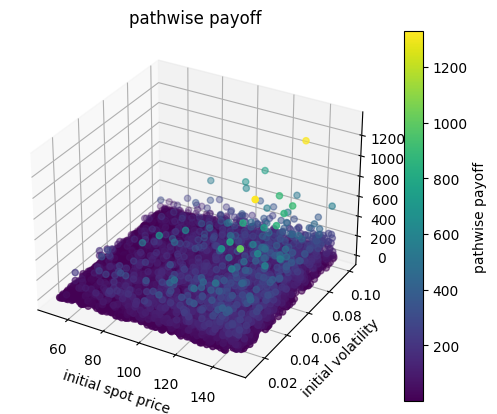

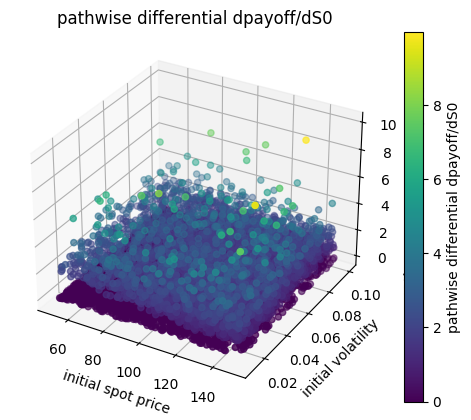

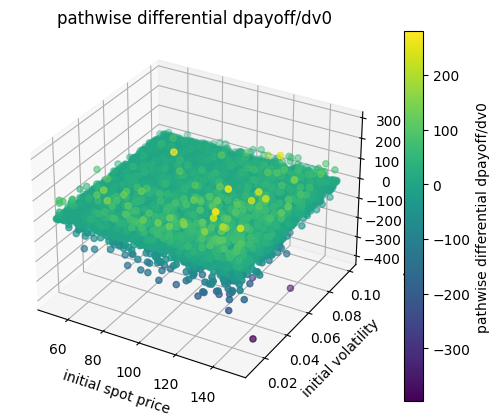

In [21]:

fig_payoff = plot_3d_differential_data(initial_spots, initial_vols, ps, "pathwise payoff")
fig_dS = plot_3d_differential_data(initial_spots, initial_vols, dps.S0, "pathwise differential dpayoff/dS0")
fig_dv = plot_3d_differential_data(initial_spots, initial_vols, dps.v0, "pathwise differential dpayoff/dv0")

# TrainingSet generation

In [10]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

class HestonTrainingSet(eqx.Module):
    initial_states: Array
    payoffs: Array
    differentials: ModelState
    
    def as_flattened_dict(self):
        d = asdict(self)

        d["payoffs"] = jnp.ravel(d["payoffs"])
        d["initial_states"] = jnp.reshape(d["initial_states"], (-1, d["initial_states"].shape[-1]))
        d["differentials"] = jnp.stack(jax.tree_util.tree_flatten(jax.tree_util.tree_map(jnp.ravel, ds.differentials))[0], axis=1)
        return d

    def metadata(self, spot_range: Range, vol_range: Range):
        return {"spot_range": asdict(spot_range), "vol_range": asdict(vol_range), "n_samples": self.payoffs.size}

def training_set_precomputed(params: Heston.Parameters, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range) -> HestonTrainingSet:

    def training_set_precomputed_inner(carry, key):
        n_inner_paths = 2**15
        # key, key_spots, key_vols = jrandom.split(key, 3)
        key, key_state = jrandom.split(key, 2)
        # initial_spots = jrandom.uniform(key_spots, shape=(n_inner_paths,), minval=spot_range.minval, maxval=spot_range.maxval)
        # initial_vols = jrandom.uniform(key_vols, shape=(n_inner_paths,), minval=vol_range.minval, maxval=vol_range.maxval)

        
        initial_states = jrandom.uniform(key_state, shape=(n_inner_paths, 2), minval=jnp.array([spot_range.minval, vol_range.minval]), maxval=jnp.array([spot_range.maxval, vol_range.maxval]))
        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]
        
        # initial_spots = jnp.ones(n_inner_paths) * 100.0
        # initial_vols = jnp.ones(n_inner_paths) * 0.09    
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
        
        return carry, HestonTrainingSet(initial_states, ps, dps)
    
    # due to limited vram of gpu we need to split up the computation into outer and inner paths.
    n_outer_paths = 2**6
    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, dataset = jax.lax.scan(training_set_precomputed_inner, None, key_rngs)
    return dataset

In [46]:
key = jrandom.PRNGKey(0)

spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

ds = training_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

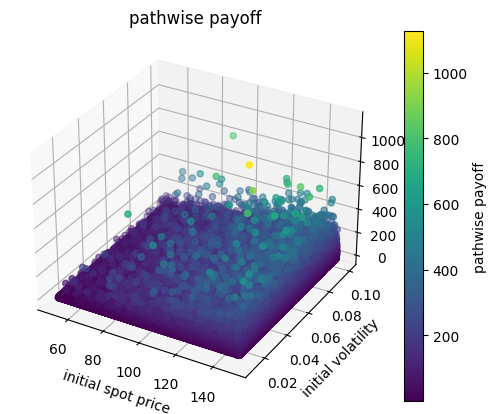

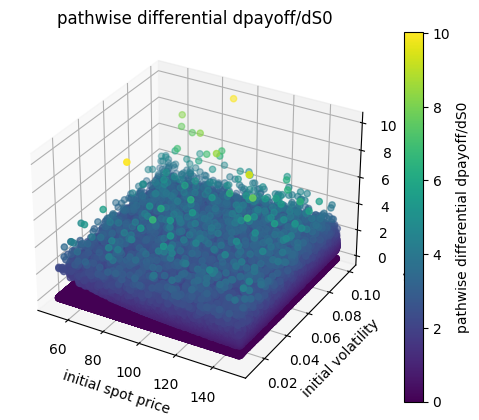

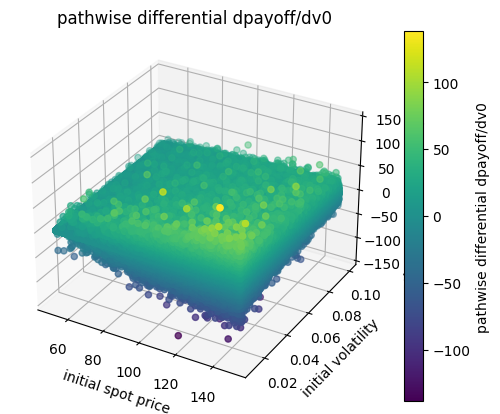

In [172]:
xs = ds.initial_states[..., 0]
ys = ds.initial_states[..., 1]

fig_payoff = plot_3d_differential_data(xs, ys, ds.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, ds.differentials.S0, "pathwise differential dpayoff/dS0")
fig_dv = plot_3d_differential_data(xs, ys, ds.differentials.v0, "pathwise differential dpayoff/dv0")

In [47]:
def uniform_mean(range):
    return (range.minval + range.maxval) / 2.0

def uniform_std(range):
    return jnp.sqrt((range.maxval - range.minval)**2 / 12)

# compute x mean and std dev. from uniform dist. properties
spot_mean = uniform_mean(spot_range)
print(spot_mean)
vol_mean = uniform_mean(vol_range)
print(vol_mean)
x_mean = jnp.stack((spot_mean, vol_mean))
print("mean computed: ", x_mean)

spot_std = uniform_std(spot_range)
print(spot_std)
vol_std = uniform_std(vol_range)
print(vol_std)

x_std = jnp.stack((spot_std, vol_std))
print("stddev computed: ", x_std)


100.0
0.055
mean computed:  [1.0e+02 5.5e-02]
28.867513459481287
0.025980762113533163
stddev computed:  [2.88675135e+01 2.59807621e-02]


In [48]:
def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std
    
def add_normalized_columns(ds):
    ds["normalized_initial_states"] = normalize(ds["initial_states"], x_mean, x_std) 
    
    payoffs = ds["payoffs"]
    ds["normalized_payoffs"] = normalize(payoffs, jnp.mean(payoffs), jnp.std(payoffs))
    return ds

In [55]:
def save_train_dataset(ds: HestonTrainingSet, spot_range: Range, vol_range: Range):
    train_data_dict = add_normalized_columns(ds.as_flattened_dict())
    
    citation = r"""@misc{dataset:heston,
        author = {Kichler, Neil},
        year = {2023},
        title = {{Heston Dataset}},
        howpublished= {\url{https://github.com/neilkichler/diff-ml/tree/main/datasets/bachelier}}
    """
    
    spot_minval = spot_range.minval
    spot_maxval = spot_range.maxval
    vol_minval = vol_range.minval
    vol_maxval = vol_range.maxval
    
    ds_info = DatasetInfo(
        description=f"Example data of a Heston model for a european call option. The generated data has initial spot range of: [{spot_minval}, {spot_maxval}] and volatility range of: [{vol_minval}, {vol_maxval}].",
        homepage="https://github.com/neilkichler/diff-ml/tree/main/datasets/heston",
        license="MIT License",
        citation=citation,
        version="1.1.0",
    )
    
    train_dataset = Dataset.from_dict(train_data_dict, info=ds_info, split="train")
    train_dataset = train_dataset.with_format("jax")
    save_folder = f"datasets/heston/arrow/payoffs/spot_{spot_minval}_to_{spot_maxval}_vol_{vol_minval}_to_{vol_maxval}"
    train_dataset.save_to_disk(save_folder)
    
    # save metadata
    
    import json
    
    ds_json = ds.metadata(spot_range, vol_range)
    
    with open(f"{save_folder}/metadata.json", 'w') as f:
        json.dump(ds_json, f)

In [56]:
save_train_dataset(ds, spot_range, vol_range)

Saving the dataset (0/1 shards):   0%|          | 0/2097152 [00:00<?, ? examples/s]

In [53]:
train_dataset_loaded = load_from_disk(save_folder)
print(train_dataset_loaded)

ds_gen = train_dataset_loaded.iter(batch_size=512)
for d in ds_gen:
    jax.tree_util.tree_map(lambda x: print(x.shape), d)
    break

Dataset({
    features: ['initial_states', 'payoffs', 'differentials', 'normalized_initial_states', 'normalized_payoffs'],
    num_rows: 2097152
})
(512, 2)
(512, 2)
(512, 2)
(512,)
(512,)


In [54]:
# Now the same but with larger vol range

key = jrandom.PRNGKey(0)

# TODO: should this be part of the HestonParams class?
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 1.0)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

ds = training_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

In [57]:
save_train_dataset(ds, spot_range, vol_range)

Saving the dataset (0/1 shards):   0%|          | 0/2097152 [00:00<?, ? examples/s]

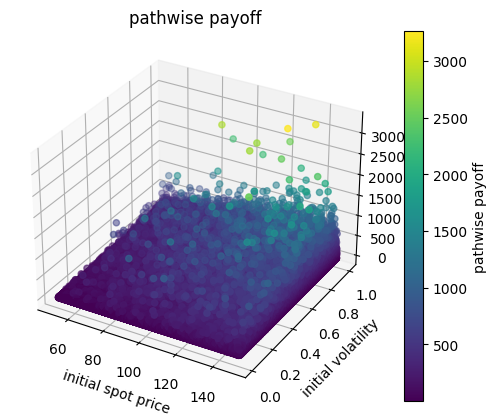

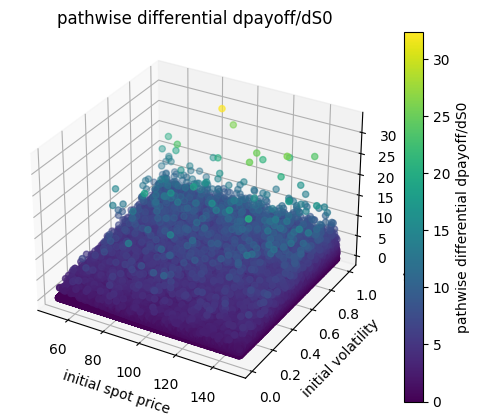

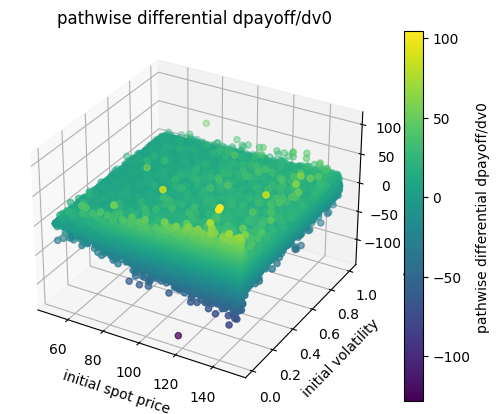

In [240]:
xs = ds.initial_states[..., 0]
ys = ds.initial_states[..., 1]

fig_payoff = plot_3d_differential_data(xs, ys, ds.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, ds.differentials.S0, "pathwise differential dpayoff/dS0")
fig_dv = plot_3d_differential_data(xs, ys, ds.differentials.v0, "pathwise differential dpayoff/dv0")

# TestSet generation, large volatility

In [94]:
class HestonTestSet(eqx.Module):
    initial_states: Array
    prices: Array
    greeks: ModelState
    
    def as_flattened_dict(self):
        d = asdict(self)
        d["greeks"] = jnp.stack(self.greeks, axis=1)
        return d

    def metadata(self, spot_range: Range, vol_range: Range):
        return {"spot_range": asdict(spot_range), "vol_range": asdict(vol_range), "n_samples": self.prices.size}

@eqx.filter_jit
def test_set_precomputed(params: Heston.Parameters, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range) -> HestonTestSet:

    minvals = jnp.array([spot_range.minval, vol_range.minval])
    maxvals = jnp.array([spot_range.maxval, vol_range.maxval])
    
    def test_set_precomputed_inner(carry, key):
        n_inner_paths = 2**15
        key, key_state = jrandom.split(key)

        # inisde the inner loop of the test set we always use the same initial state to determine the price afterwards.
        initial_states = jnp.ones((n_inner_paths, 2)) * jrandom.uniform(key_state, shape=(2,), minval=minvals, maxval=maxvals)
        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]
        
        # jax.debug.print("initial spots {}", initial_spots)
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
        # jax.lax.cond(carry % 100, lambda x: jax.debug.print("finished price calcuation {}", x), lambda _: None, carry)
        jax.debug.print("finished price calcuation {}", carry)
        return carry + 1, HestonTestSet(initial_states, ps, dps)
    
    # due to limited vram of gpu we need to split up the computation into outer and inner paths.
    n_outer_paths = 2**10
    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, ds = jax.lax.scan(test_set_precomputed_inner, 0, key_rngs)

    # jax.debug.print("ds payoffs {}", ds.payoffs.shape)
    # jax.debug.print("ds payoffs {}", ds.payoffs)

    def discounted_avg(x, h: Heston.Parameters):
        return jnp.mean(x, axis=1) * jnp.exp(-h.r * h.T) 
    
    test_set = HestonTestSet(*astuple(jax.tree_util.tree_map(partial(discounted_avg, h=hs_params), ds)))

    # jax.debug.print("test set {}", test_set)
    
    return test_set

In [95]:
key = jrandom.PRNGKey(0)

spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 10.0)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

test_set_high_vol = test_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

finished price calcuation 0
finished price calcuation 1
finished price calcuation 2
finished price calcuation 3
finished price calcuation 4
finished price calcuation 5
finished price calcuation 6
finished price calcuation 7
finished price calcuation 8
finished price calcuation 9
finished price calcuation 10
finished price calcuation 11
finished price calcuation 12
finished price calcuation 13
finished price calcuation 14
finished price calcuation 15
finished price calcuation 16
finished price calcuation 17
finished price calcuation 18
finished price calcuation 19
finished price calcuation 20
finished price calcuation 21
finished price calcuation 22
finished price calcuation 23
finished price calcuation 24
finished price calcuation 25
finished price calcuation 26
finished price calcuation 27
finished price calcuation 28
finished price calcuation 29
finished price calcuation 30
finished price calcuation 31
finished price calcuation 32
finished price calcuation 33
finished price calcuatio

In [96]:
import json

def save_test_dataset(ds: HestonTrainingSet, spot_range: Range, vol_range: Range, label = "prices"):
    data_dict = ds.as_flattened_dict()
    
    citation = r"""@misc{dataset:heston,
        author = {Kichler, Neil},
        year = {2023},
        title = {{Heston Prices Large Volatility Range Dataset}},
        howpublished= {\url{https://github.com/neilkichler/diff-ml/tree/main/datasets/bachelier}}
    """
    
    spot_minval = spot_range.minval
    spot_maxval = spot_range.maxval
    vol_minval = vol_range.minval
    vol_maxval = vol_range.maxval

    
    ds_info = DatasetInfo(
        description=f"MC-Sampled {label} of a Heston model for a european call option. The generated data has initial spot range of: [{spot_minval}, {spot_maxval}] and volatility range of: [{vol_minval}, {vol_maxval}].",
        homepage="https://github.com/neilkichler/diff-ml/tree/main/datasets/heston",
        license="MIT License",
        citation=citation,
        version="1.1.0",
    )
    
    train_dataset = Dataset.from_dict(data_dict, info=ds_info, split="test")
    train_dataset = train_dataset.with_format("jax")
    save_folder = f"datasets/heston/arrow/{label}/spot_{spot_minval}_to_{spot_maxval}_vol_{vol_minval}_to_{vol_maxval}"
    train_dataset.save_to_disk(save_folder)
    
    # save metadata in separate metadata.json file
    ds_json = ds.metadata(spot_range, vol_range)
    
    with open(f"{save_folder}/metadata.json", 'w') as f:
        json.dump(ds_json, f)

    return save_folder

In [97]:
fpath = save_test_dataset(test_set_high_vol, spot_range, vol_range, label="prices")

Saving the dataset (0/1 shards):   0%|          | 0/1024 [00:00<?, ? examples/s]

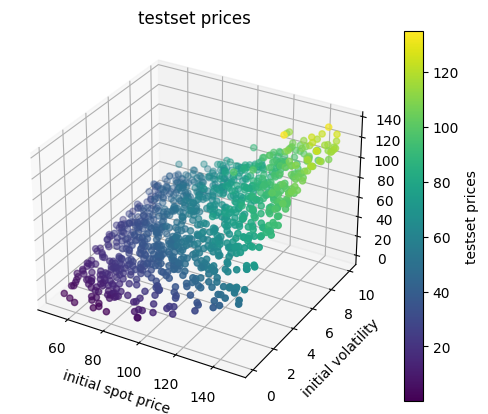

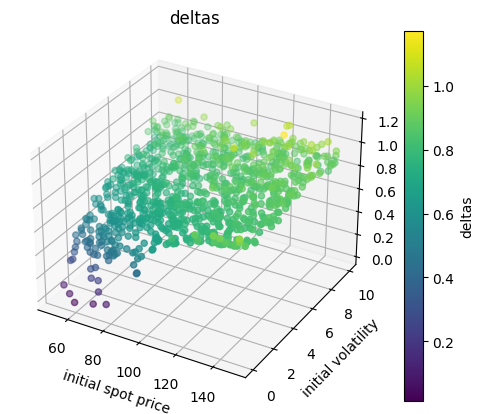

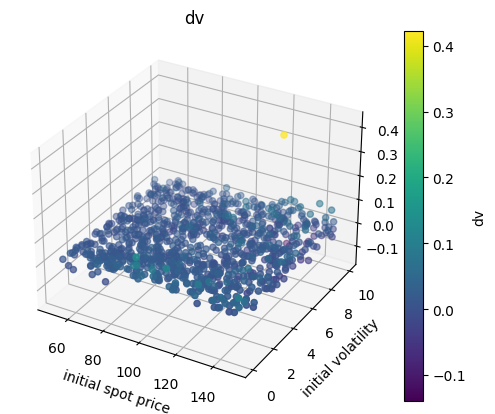

In [99]:
test_set_high_vol = load_from_disk(fpath)

xs = test_set_high_vol["initial_states"]
ys = test_set_high_vol["prices"]
greeks = test_set_high_vol["greeks"]
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "testset prices")
fig_dS = plot_3d_differential_data(xs[:, 0], xs[:, 1], greeks[:, 0], "deltas")
fig_dS = plot_3d_differential_data(xs[:, 0], xs[:, 1], greeks[:, 1], "dv")

# TestSet generation, small volatility

In [100]:
key = jrandom.PRNGKey(0)

# TODO: should this be part of the HestonParams class?
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

test_set_low_vol = test_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)


finished price calcuation 0
finished price calcuation 1
finished price calcuation 2
finished price calcuation 3
finished price calcuation 4
finished price calcuation 5
finished price calcuation 6
finished price calcuation 7
finished price calcuation 8
finished price calcuation 9
finished price calcuation 10
finished price calcuation 11
finished price calcuation 12
finished price calcuation 13
finished price calcuation 14
finished price calcuation 15
finished price calcuation 16
finished price calcuation 17
finished price calcuation 18
finished price calcuation 19
finished price calcuation 20
finished price calcuation 21
finished price calcuation 22
finished price calcuation 23
finished price calcuation 24
finished price calcuation 25
finished price calcuation 26
finished price calcuation 27
finished price calcuation 28
finished price calcuation 29
finished price calcuation 30
finished price calcuation 31
finished price calcuation 32
finished price calcuation 33
finished price calcuatio

In [101]:
fpath = save_test_dataset(test_set_low_vol, spot_range, vol_range, label="prices")

Saving the dataset (0/1 shards):   0%|          | 0/1024 [00:00<?, ? examples/s]

# Load Dataset for training

In [13]:
import json

In [14]:
def load_dataset(fpath):
    ds = load_from_disk(fpath)
    ds = ds.with_format("jax")

    with open(f"{fpath}/metadata.json", "r") as f:
        metadata = json.load(f)
    return ds, metadata

In [17]:
train_dataset, meta_train = load_dataset("datasets/heston/arrow/payoffs/spot_50.0_to_150.0_vol_0.01_to_0.1")
test_dataset, meta_test = load_dataset("datasets/heston/arrow/prices/spot_50.0_to_150.0_vol_0.01_to_0.1")


In [18]:
jnp.max(train_dataset["initial_states"][:, 1])

Array(0.09999994, dtype=float32)

# Test dataset visualization

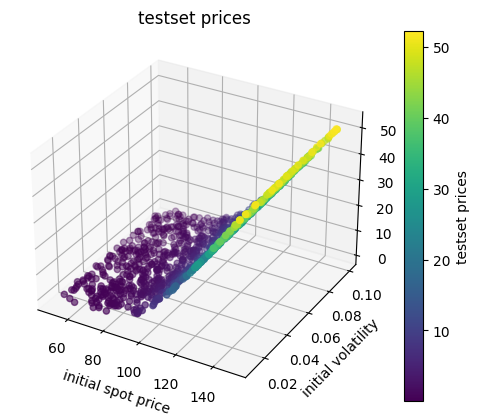

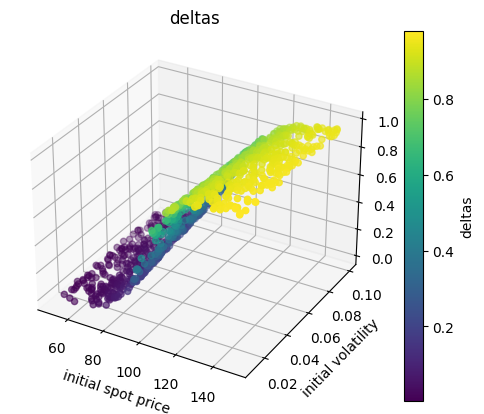

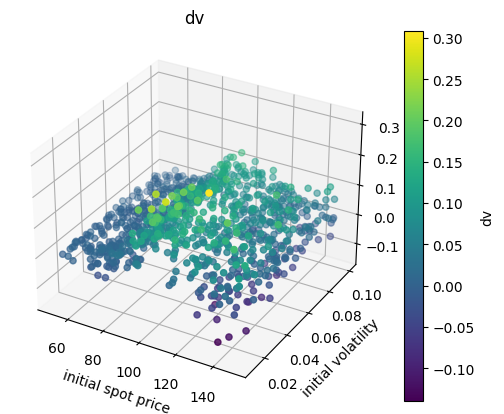

In [26]:
xs = test_dataset["initial_states"]
xs, ys = xs[:, 0], xs[:, 1]
zs = test_dataset["prices"]
greeks = test_dataset["greeks"]
fig_payoff = plot_3d_differential_data(xs, ys, zs, "testset prices")
fig_dS = plot_3d_differential_data(xs, ys, greeks[:, 0], "deltas")
fig_dS = plot_3d_differential_data(xs, ys, greeks[:, 1], "dv")

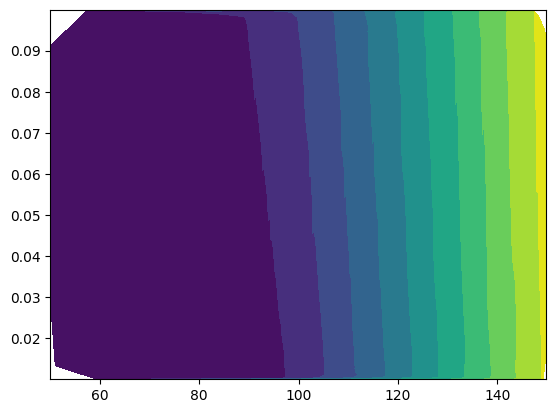

In [27]:
plt.tricontourf(xs, ys, zs, levels = 10)
plt.show()

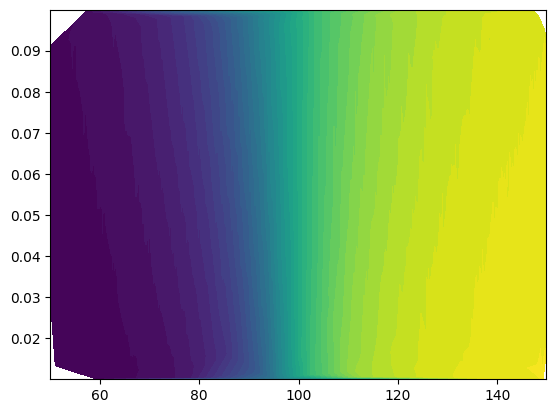

In [28]:
plt.tricontourf(xs, ys, greeks[:, 0], levels=40)
plt.show()

0


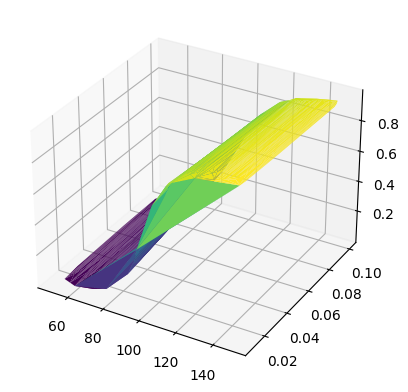

In [29]:
import matplotlib.tri as mtri

# Make parameter spaces radii and angles.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi/n_angles


x = xs
y = ys

triang = mtri.Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = (xmid**2 + ymid**2) < min_radius**2

print(np.sum(mask))
triang.set_mask(mask)

z = greeks[:, 0]

# Plot the surface.
# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = fig.add_subplot(1, 2, 2, projection='3d')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(triang, z, cmap=plt.cm.viridis) #CMRmap)


plt.show()

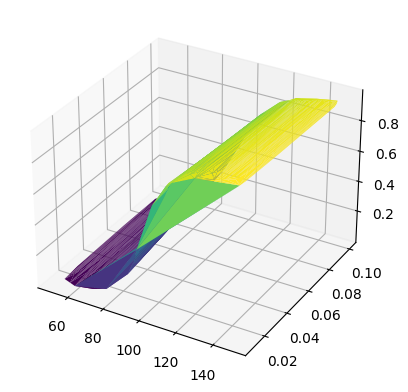

In [30]:

x = xs
y = ys

tri = mtri.Triangulation(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.viridis) #, cmap=plt.cm.Spectral)



# Train Standard ML

In [31]:
Model = Callable[[Array, Optional[PRNGKeyArray]], Array]


class Normalization(eqx.Module):
    """Preprocessing layer to receive normalized input.

    Similar to `Normalization` layer of Keras.
    """

    mean: Float[Array, ""]
    std: Float[Array, ""]

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        res = (x - self.mean) / self.std
        # jax.debug.print("normalized x is: {}", res)
        return res

class Denormalization(eqx.Module):
    """Preprocessing layer to denormalize data to original scale."""

    mean: Float[Array, ""]
    std: Float[Array, ""]

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        res = x * self.std + self.mean
        # jax.debug.print("normalized y was: {}", x)
        # jax.debug.print("denormalized y is: {}", res)
        return res

class Normalized(eqx.Module):
    seq: eqx.nn.Sequential

    def __init__(
        self,
        x_normalizer: Normalization,
        model: eqx.Module,
        y_denormalizer: Denormalization,
    ):
        self.seq = eqx.nn.Sequential(layers=(x_normalizer, model, y_denormalizer))

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return self.seq(x, key=key)

In [32]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

In [34]:
using_normalized_dataset=True
if using_normalized_dataset:
    key = jrandom.PRNGKey(0)
    key, subkey = jrandom.split(key)
    
    class Range(eqx.Module):
        minval: float = 0.0
        maxval: float = 1.0
    # this info should perhaps be stored inside the dataset?
    spot_range = Range(50.0, 150.0)
    vol_range = Range(0.01, 1.0)
    
    
    ds = train_dataset
    
    
    def uniform_mean(range):
        return (range.minval + range.maxval) / 2.0
    
    def uniform_std(range):
        return jnp.sqrt((range.maxval - range.minval)**2 / 12)
    
    # compute x mean and std dev. from uniform dist. properties
    spot_mean = uniform_mean(spot_range)
    print(spot_mean)
    # print(jnp.mean(ds["initial_spots"]))
    
    vol_mean = uniform_mean(vol_range)
    print(vol_mean)
    # print(jnp.mean(ds["initial_vols"]))
    
    x_mean = jnp.stack((spot_mean, vol_mean))#[:, jnp.newaxis]
    print("mean computed: ", x_mean)
    print("mean data: ", jnp.mean(ds["initial_states"], axis=0))
    
    spot_std = uniform_std(spot_range)
    print(spot_std)
    
    print(vol_range)
    vol_std = uniform_std(vol_range)
    print(vol_std)
    
    x_std = jnp.stack((spot_std, vol_std))#[:, jnp.newaxis]
    print("stddev computed: ", x_std)
    print("stddev data: ", jnp.std(ds["initial_states"], axis=0))
    
    # compute y mean and std. dev. from data
    y_mean = jnp.mean(ds["payoffs"])
    y_std = jnp.std(ds["payoffs"])
    
    # ds["payoffs"] = (ds["payoffs"] - y_mean) / y_std
    
    def normalize_payoffs(example):
        example["payoffs"] = (example["payoffs"] - y_mean) / y_std
    
    # ds = ds.map(normalize_payoffs, batched=True)
    # print(ds)
    # print(jnp.mean(ds["payoffs"]))
    # print(jnp.max(ds["payoffs"]))
    
    # print(type(ds["payoffs"]))
    # ds["payoffs"] = ds["payoffs"] * 2.0 
    # ds.add_column("payoff_normalized", (ds["payoffs"] - y_mean) / y_std)
    
    # surrogate model initialization
    # x_normalizer = Normalization(mean=x_mean, std=x_std)
    # y_denormalizer = Denormalization(mean=y_mean, std=y_std)
    # surrogate_model = Normalized(x_normalizer, mlp, y_denormalizer)

100.0
0.505
mean computed:  [100.      0.505]
mean data:  [1.0004014e+02 5.4994348e-02]
28.867513459481287
Range(minval=0.01, maxval=1.0)
0.28578838324886474
stddev computed:  [28.86751346  0.28578838]
stddev data:  [2.8855728e+01 2.5990786e-02]


In [35]:
train_ds = train_dataset
train_ds = train_ds[:16 * 1024]

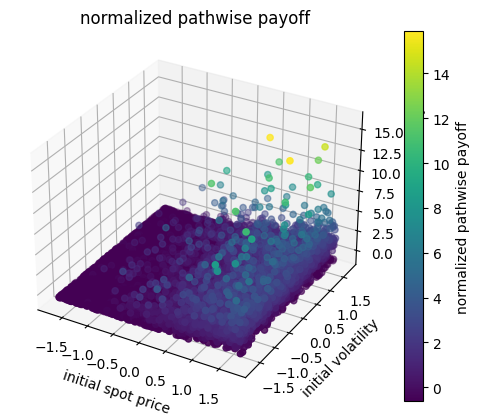

In [37]:
n_samples = 2**20
xs = train_ds["normalized_initial_states"][:n_samples]
ys = train_ds["normalized_payoffs"][:n_samples]
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "normalized pathwise payoff")


In [38]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]

def mse(y, pred_y):
    """Mean squared error loss."""
    return jnp.mean((y - pred_y) ** 2)


def loss_fn(
    model, x, y
):
    pred_y = vmap(model)(x)
    # jax.debug.print("pred_y is {}", pred_y)
    # jax.debug.print("true_y is {}", y)
    # jax.debug.print("y: {}", y.shape)
    # jax.debug.print("pred_y: {}", (y-pred_y).shape)
    # jax.debug.print("y - pred_y: {}", jnp.mean((y-pred_y)**2))
    return mse(y, pred_y)


using_tf_style = False

def train(
    model: PyTree,
    train_data: DataGenerator,
    test_data: Optional[Data],
    optim: optax.GradientTransformation,
    n_epochs: int,
) -> PyTree:
    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch: Data):

        if using_tf_style:
            x, y = batch
        else:
            x = batch["normalized_initial_states"]
            y = batch["normalized_payoffs"]
        
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps_per_epoch = 64
    n_steps = n_epochs * n_steps_per_epoch
    print(n_steps)

    if not using_tf_style:
        for i, batch in zip(range(n_steps), train_data):
            model, opt_state, train_loss = train_step(model, opt_state, batch)
    
            if i % n_steps_per_epoch == 0 or i == n_steps-1:
                epoch_stats = f"Finished epoch {i} | Train Loss: {train_loss:.5f}"    
                print(epoch_stats)

        # def train_inner(model, opt_state, train_loss):
        #     batch = next(train_data)
        #     model, opt_state, train_loss = train_step(model, opt_state, batch)
    
        #     if i % n_steps_per_epoch == 0:
        #         epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
        #         print(epoch_stats)
    
        #     return model, opt_state, train_loss
        
        # model = jax.lax.fori_loop(0, n_steps, train_inner, (model, opt_state, train_loss))
    else: 
        for epoch in range(n_epochs):
            for batch in train_data:
                model, opt_state, train_loss = train_step(model, opt_state, batch)
                # print(f"batch {i} finished")
                
            epoch_stats = f"Finished epoch {epoch:3d} | Train Loss: {train_loss:.5f}"
    
            if test_data:
                test_loss = jnp.sqrt(loss_fn(model, test_data["spot"], test_data["payoff"]))
                print(f"{epoch_stats} | Test Loss: {test_loss:.5f}")
            else:
                print(epoch_stats)

    return model

In [39]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# in_size is 2 for initial_spot and initial_vol
n_dims = 2
mlp = eqx.nn.MLP(key=subkey, in_size=n_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)

key, subkey = jax.random.split(key)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp

In [66]:
#tf_ds = ds.with_format("tf")

In [196]:
tf_ds

Dataset({
    features: ['initial_states', 'payoffs', 'differentials', 'normalized_initial_states', 'normalized_payoffs'],
    num_rows: 2097152
})

In [318]:
BATCH_SIZE = 512

tf_train_dataset = tf.data.Dataset.from_tensor_slices((ds["normalized_initial_states"], ds["normalized_payoffs"]))

tf_train_dataset = tf_train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

tf_generator_train_ds = tfds.as_numpy(tf_train_dataset)
# generator_test_ds = tfds.as_numpy(test_dataset)

In [37]:
tf_train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [55]:
len(ds["payoffs"])

2097152

In [41]:
n_epochs = 100
BATCH_SIZE = 512

if using_tf_style:
    generator_train_ds = tf_generator_train_ds
else:
    generator_train_ds = train_dataset.iter(batch_size=BATCH_SIZE)

generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

total_steps = 128 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=3e-4)


# for batch in generator_train_ds:
#     x = jnp.stack((batch["initial_spots"], batch["initial_vols"]))
#     y = batch["payoffs"]
#     print(x.shape)
#     print(y.shape)
#     break
    
surrogate_model = train(surrogate_model, generator_train_ds, generator_test_ds, optim, n_epochs=n_epochs)


6400
Finished epoch 0 | Train Loss: 1.18022
Finished epoch 64 | Train Loss: 0.76685
Finished epoch 128 | Train Loss: 0.75549
Finished epoch 192 | Train Loss: 0.59245
Finished epoch 256 | Train Loss: 0.43590
Finished epoch 320 | Train Loss: 0.53414
Finished epoch 384 | Train Loss: 0.83216
Finished epoch 448 | Train Loss: 0.64195
Finished epoch 512 | Train Loss: 0.74426
Finished epoch 576 | Train Loss: 0.51566
Finished epoch 640 | Train Loss: 0.59851
Finished epoch 704 | Train Loss: 0.40987
Finished epoch 768 | Train Loss: 0.59323
Finished epoch 832 | Train Loss: 0.67388
Finished epoch 896 | Train Loss: 0.56208
Finished epoch 960 | Train Loss: 0.63162
Finished epoch 1024 | Train Loss: 0.76398
Finished epoch 1088 | Train Loss: 0.41421
Finished epoch 1152 | Train Loss: 0.50821
Finished epoch 1216 | Train Loss: 0.60675
Finished epoch 1280 | Train Loss: 0.48454
Finished epoch 1344 | Train Loss: 0.55901
Finished epoch 1408 | Train Loss: 0.51363
Finished epoch 1472 | Train Loss: 0.48439
Finish

In [132]:
xs = ds["normalized_initial_states"]
pred_y = vmap(surrogate_model)(xs)
print(pred_y)

for i, p in enumerate(pred_y):
    print(p)
    if i == 1000:
        break

[ 1.48656161 -0.62139155  0.25534295 ... -0.61387657  0.35475823
  0.55235523]
1.4865616144830835
-0.6213915540991952
0.2553429480266797
-0.26332863439831067
-0.5354571901548966
-0.581759139422843
-0.6255228160242066
-0.6307761771592368
-0.12151118811214584
-0.5405941548087936
-0.27716726968090316
-0.6019641234988424
0.510434674701136
-0.4148505902407859
0.1391533337948569
-0.2117214574906489
-0.5238550126242163
0.0122664089062052
-0.39182564758103894
-0.2476995701279659
-0.19986267656284967
1.1528053964216947
-0.6354145323241276
-0.6135662671278421
-0.6299477052622
-0.3756595801981621
-0.5692133762887817
-0.6327858300171405
0.7370319730362114
-0.51128115704613
-0.6279900941566605
-0.5917418316656748
-0.5900825536167256
0.5237253434882352
-0.2396453630770598
-0.6105871538858667
-0.5113751347531941
1.1868915983956283
1.0713734216055895
0.14561739113915295
-0.6362295670946521
0.5848253372880438
0.3608471048728126
-0.4455571000110706
0.4734355581946523
-0.5640241842785159
-0.6273794023497

In [133]:
for i, p in enumerate(ds["normalized_payoffs"]):
    print(p)
    if i == 1000:
        break

1.5599705
-0.6105691
0.59901226
1.3945678
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.32914633
-0.6105691
-0.6105691
-0.6105691
-0.4006324
-0.6105691
-0.3732554
-0.6105691
-0.6105691
-0.5458564
-0.25116682
-0.24844593
-0.6105691
2.3837037
-0.6105691
-0.6105691
-0.6105691
0.21960327
-0.6105691
-0.6105691
-0.5138466
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
1.3219992
1.0868182
-0.6105691
-0.6105691
-0.00077116134
0.13405849
0.5818911
0.6824991
-0.6105691
-0.6105691
-0.6105691
-0.42336786
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
0.3435998
0.3559572
0.54755354
-0.6105691
-0.14351185
-0.36042508
-0.6105691
-0.43305162
-0.22985224
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
0.5828841
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.6105691
-0.26587644
1.7622297
2.0413158
0.56443465
-0.6105691
-0.6105691
-0.6105691
1.4410099
-0.6105691
-0.026213605
0.39391455
-0.17926566
-0.6105691
1.1792666
-0.10330

In [43]:
# mse(pred_y, ds["normalized_payoffs"])
# on the test data
test_normalized_xs = test_dataset["initial_states"]
test_normalized_xs = (test_normalized_xs - x_mean) / x_std
test_normalized_ys = test_dataset["prices"]
test_normalized_ys = (test_normalized_ys - y_mean) / y_std

test_normalized_pred_ys = vmap(surrogate_model)(test_normalized_xs)
jnp.sqrt(mse(test_normalized_pred_ys, test_normalized_ys))


Array(0.03162257, dtype=float64)

In [44]:
test_normalized_pred_ys

Array([-0.56935845, -0.28560799,  1.14252268, ..., -0.540464  ,
       -0.10463631, -0.02288044], dtype=float64)

In [53]:
test_normalized_ys

Array([-0.60202295, -0.31816506,  1.1286956 , ..., -0.56904554,
       -0.1407721 ,  0.04628098], dtype=float32)

In [58]:
jnp.abs(test_normalized_pred_ys - test_normalized_ys)

Array([0.03266449, 0.03255707, 0.01382708, ..., 0.02858155, 0.03613579,
       0.06916143], dtype=float64)

In [59]:
res = surrogate_model((jnp.array([100.0, 0.09]) - x_mean) / x_std)
print(res * y_std + y_mean)

8.389521088696217


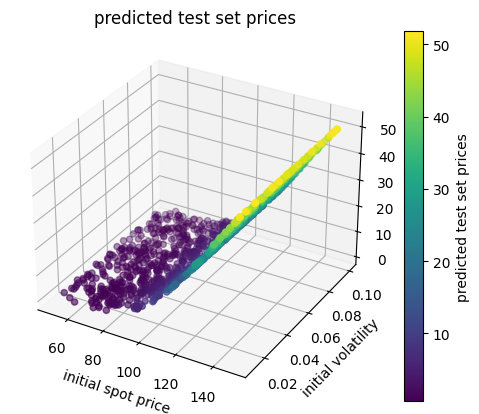

In [47]:
xs = test_dataset["initial_states"]
ys = test_normalized_pred_ys * y_std + y_mean
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "predicted test set prices")

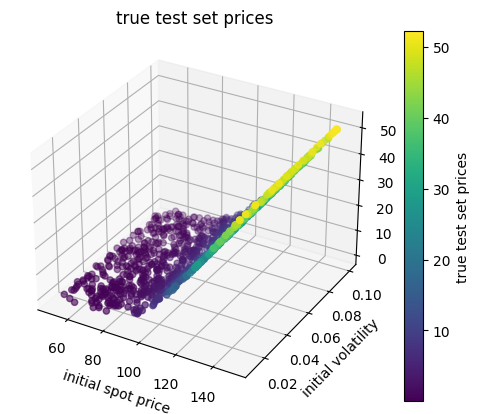

In [48]:
xs = test_dataset["initial_states"]
ys =  test_dataset["prices"]
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "true test set prices")

In [65]:
idx_closest = jnp.argmin(jnp.abs(test_dataset["initial_states"] - jnp.array([100.0,     0.09])), axis=0)

print(idx_closest)
value = test_dataset["initial_states"][idx_closest]
print(value)
test_dataset["prices"][idx_closest[0]]

[150 676]
[[9.9996597e+01 1.9248771e-02]
 [1.2303915e+02 9.0006828e-02]]


Array(6.7526445, dtype=float32)

# Differential ML

In [133]:
diff_mean = jnp.mean(train_dataset["differentials"], axis=0)

In [134]:
diff_std = jnp.std(train_dataset["differentials"], axis=0)

In [136]:
diff_normalized = (train_dataset["differentials"] - diff_mean) / diff_std

In [138]:
jnp.mean(diff_normalized, axis=0)

Array([6.6007487e-08, 1.5199475e-08], dtype=float32)

In [139]:
jnp.std(diff_normalized, axis=0)

Array([1.0000002, 0.9999998], dtype=float32)

In [145]:
state_mean = jnp.mean(train_dataset["initial_states"], axis=0)
state_std = jnp.std(train_dataset["initial_states"], axis=0)

state_norm = (train_dataset["initial_states"] - state_mean) / state_std

In [162]:
payoffs_std = jnp.std(train_dataset["payoffs"])
payoffs_std

Array(25.24694, dtype=float32)

In [163]:
(train_dataset["payoffs"] - jnp.mean(train_dataset["payoffs"])) / jnp.std(train_dataset["payoffs"])

Array([ 1.5599706 , -0.6105691 ,  0.59901243, ..., -0.6105691 ,
        0.531328  , -0.592333  ], dtype=float32)

In [146]:
state_norm

Array([[ 1.7227458 ,  0.194156  ],
       [-1.0183268 , -0.35888124],
       [ 0.59454   ,  1.2739062 ],
       ...,
       [-1.0027976 ,  0.57845414],
       [ 0.69086915,  0.93475026],
       [ 0.86468804,  0.91699785]], dtype=float32)

In [167]:
normalized_differentials = (train_dataset["differentials"] / payoffs_std) * state_std

In [169]:
print(jnp.mean(normalized_differentials, axis=0))
print(jnp.std(normalized_differentials, axis=0))

[5.912224e-01 5.539442e-05]
[0.65514374 0.00751905]


In [166]:
train_dataset["differentials"][0][1] * state_std[1] / payoffs_std

Array(0.0267854, dtype=float32)

In [158]:
state_std[1]

Array(0.02599079, dtype=float32)

In [170]:
state_std

Array([2.8855728e+01, 2.5990786e-02], dtype=float32)

In [181]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch ..."], y: Float[Array, "batch ..."], dydx: Float[Array, "batch ..."]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    # normalize dydx since the predictions are normalized. TODO: should happen somewhere else
    dydx_scaled = (dydx / payoffs_std) * state_std
    
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = jnp.mean((y_pred - y)**2)
    # jax.debug.print("value loss: {}", value_loss)
    grad_loss = jnp.mean((dydx_pred - dydx_scaled)**2)
    # jax.debug.print("dydx_pred: {}", dydx_pred)
    # jax.debug.print("dydx_true: {}", dydx_scaled)
    loss = alpha * value_loss + beta * grad_loss

    jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [ ]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]

def mse(y, pred_y):
    """Mean squared error loss."""
    return jnp.mean((y - pred_y) ** 2)


def loss_fn(
    model, x, y
):
    pred_y = vmap(model)(x)
    # jax.debug.print("pred_y is {}", pred_y)
    # jax.debug.print("true_y is {}", y)
    # jax.debug.print("y: {}", y.shape)
    # jax.debug.print("pred_y: {}", (y-pred_y).shape)
    # jax.debug.print("y - pred_y: {}", jnp.mean((y-pred_y)**2))
    return mse(y, pred_y)


using_tf_style = False

def train(
    model: PyTree,
    train_data: DataGenerator,
    test_data: Optional[Data],
    optim: optax.GradientTransformation,
    n_epochs: int,
) -> PyTree:
    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch: Data):

        if using_tf_style:
            x, y = batch
        else:
            x = batch["normalized_initial_states"]
            y = batch["normalized_payoffs"]
        
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps_per_epoch = 256
    n_steps = n_epochs * n_steps_per_epoch

    if not using_tf_style:

        
        for i, batch in zip(range(n_steps), train_data):
            model, opt_state, train_loss = train_step(model, opt_state, batch)
    
            if i % n_steps_per_epoch == 0:
                epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
                print(epoch_stats)

        # def train_inner(model, opt_state, train_loss):
        #     batch = next(train_data)
        #     model, opt_state, train_loss = train_step(model, opt_state, batch)
    
        #     if i % n_steps_per_epoch == 0:
        #         epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
        #         print(epoch_stats)
    
        #     return model, opt_state, train_loss
        
        # model = jax.lax.fori_loop(0, n_steps, train_inner, (model, opt_state, train_loss))
    else: 
        for epoch in range(n_epochs):
            for batch in train_data:
                model, opt_state, train_loss = train_step(model, opt_state, batch)
                # print(f"batch {i} finished")
                
            epoch_stats = f"Finished epoch {epoch:3d} | Train Loss: {train_loss:.5f}"
    
            if test_data:
                test_loss = jnp.sqrt(loss_fn(model, test_data["spot"], test_data["payoff"]))
                print(f"{epoch_stats} | Test Loss: {test_loss:.5f}")
            else:
                print(epoch_stats)

    return model

In [177]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for batch in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [182]:
Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]

def diff_train(
    model: PyTree,
    train_data: DataGenerator,
    test_data: Optional[Data],
    optim: optax.GradientTransformation,
    n_epochs: int,
) -> PyTree:
    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch: Data):

        x = batch["normalized_initial_states"]
        y = batch["normalized_payoffs"]
        dydx = batch["differentials"]
        
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps_per_epoch = 256
    n_steps = n_epochs * n_steps_per_epoch
    
    for i, batch in zip(range(n_steps), train_data):
        model, opt_state, train_loss = train_step(model, opt_state, batch)

        if i % n_steps_per_epoch == 0:
            epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
            print(epoch_stats)

    return model

In [184]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# in_size is 2 for initial_spot and initial_vol
n_dims = 2
mlp = eqx.nn.MLP(key=subkey, in_size=n_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)

# key, subkey = jax.random.split(key)
# mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp

In [185]:
n_epochs = 100
BATCH_SIZE = 512

if using_tf_style:
    generator_train_ds = tf_generator_train_ds
else:
    generator_train_ds = train_dataset.iter(batch_size=BATCH_SIZE)

generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

total_steps = 128 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=3e-4)


# for batch in generator_train_ds:
#     x = jnp.stack((batch["initial_spots"], batch["initial_vols"]))
#     y = batch["payoffs"]
#     print(x.shape)
#     print(y.shape)
#     break
    
surrogate_model = diff_train(surrogate_model, generator_train_ds, generator_test_ds, optim, n_epochs=n_epochs)


[Internal] Value Loss 0.7651095711115229 | Grad Loss: 0.33128446340560913
Finished epoch   0 | Train Loss: 0.47589
[Internal] Value Loss 0.9420210679696674 | Grad Loss: 0.33208006620407104
[Internal] Value Loss 0.7299390316479399 | Grad Loss: 0.31638240814208984
[Internal] Value Loss 1.4509419719009442 | Grad Loss: 0.33638036251068115
[Internal] Value Loss 0.7187405417489852 | Grad Loss: 0.2977808713912964
[Internal] Value Loss 0.8134260416063617 | Grad Loss: 0.3055332899093628
[Internal] Value Loss 1.0323917352512992 | Grad Loss: 0.34683817625045776
[Internal] Value Loss 1.3238551798014293 | Grad Loss: 0.3186073899269104
[Internal] Value Loss 0.7659663010457158 | Grad Loss: 0.3144110441207886
[Internal] Value Loss 0.7010648539050112 | Grad Loss: 0.31724250316619873
[Internal] Value Loss 0.9574945209543162 | Grad Loss: 0.35090550780296326
[Internal] Value Loss 1.1519502170682099 | Grad Loss: 0.3282543420791626
[Internal] Value Loss 0.8492967748255023 | Grad Loss: 0.3430517613887787
[In

In [186]:
# mse(pred_y, ds["normalized_payoffs"])
# on the test data
test_normalized_xs = test_dataset["initial_states"]
test_normalized_xs = (test_normalized_xs - x_mean) / x_std
test_normalized_ys = test_dataset["prices"]
test_normalized_ys = (test_normalized_ys - y_mean) / y_std

test_normalized_pred_ys = vmap(surrogate_model)(test_normalized_xs)
jnp.sqrt(mse(test_normalized_pred_ys, test_normalized_ys))

Array(0.03015263, dtype=float64)

In [187]:
res = surrogate_model((jnp.array([100.0, 0.09]) - x_mean) / x_std)
print(res * y_std + y_mean)

7.988115250541904


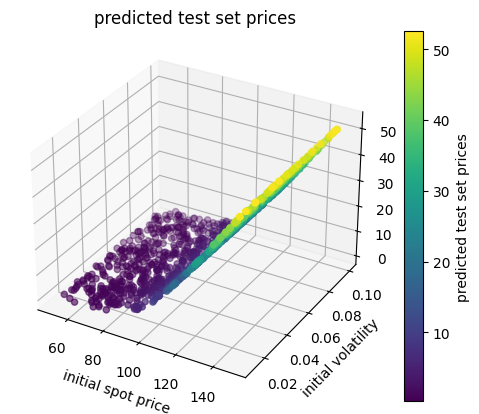

In [188]:
xs = test_dataset["initial_states"]
ys = test_normalized_pred_ys * y_std + y_mean
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "predicted test set prices")

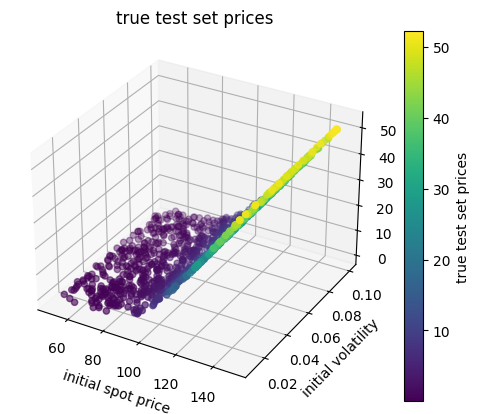

In [189]:
xs = test_dataset["initial_states"]
ys =  test_dataset["prices"]
fig_payoff = plot_3d_differential_data(xs[:, 0], xs[:, 1], ys, "true test set prices")

In [94]:
jnp.abs(test_normalized_pred_ys - test_normalized_ys)

Array([1.13525346, 0.49983755, 1.14554075, ..., 0.93511459, 0.28877691,
       0.00298771], dtype=float64)